In [ ]:
# default_exp curve_constructor

In [ ]:
%load_ext line_profiler

In [ ]:
# export
from dist_curve.pairwise_distance import component_mixture_dist_matrix
import numpy as np
from numba import njit, prange
import numba as nb

In [ ]:
nb.cuda.select_device(1)

<weakproxy at 0x7f34ccfddbf0 to Device at 0x7f34cce709d0>

In [ ]:
# hide
import matplotlib.pyplot as plt

In [ ]:
# export
@nb.jit((nb.float64[:,:], nb.float64[:,:], nb.boolean[:,:]),nopython=True, parallel=True)
def makeCurvesFromDistanceMatrix(dist_matrix,curves, mixtureInstanceRemaining):
    """
    Construct multiple distance curves, using the precomputed distances
    Arguments:
        - dist_matrix : float[num_component_instances, num_mixture_instances]
            dist_matrix[i,j] contains the distance between component instance i and mixture instance j
            
        - curves : float[num_curves_to_average, num_mixture_instances]
            matrix to fill with distance curves (passed initialized matrix because jit in no python mode can't create matrices)
            
        - mixtureInstanceRemaining : boolean[num_curves_to_average, num_mixture_instances]
            boolean matrix indicating whether the given mixture instance should be considered when constructing the curve at that iteration
            At each iteration, the mixture point that is closest to the sampled component instance is removed from consideration in subsequent iterations
            Pass matrix initialized to all True in order for all mixture instances to be considered in curve construction
    """
    assert dist_matrix.shape[1] == curves.shape[1], "dist_matrix and curves should have second dimension of size equal to the number of mixture instances"
    assert curves.shape[1] == mixtureInstanceRemaining.shape[1], "mixtureInstanceRemaining should have second dimension of size equal to the number of mixture instances"
    assert curves.shape[0] == mixtureInstanceRemaining.shape[0], "curves and mixtureInstanceRemaining should have first dimension of size equal to the number of curves being constructed"
    n_comp,n_mix = dist_matrix.shape
    for curve_num in prange(curves.shape[0]):
        componentChoices = np.random.randint(0,n_comp,size=n_mix)
        for i in range(n_mix):
            # of the remaining mixture instances, get the index (within the list of remaining)
            #     of the instance closest to the component instance
            choice = componentChoices[i]
            remainingIndices = mixtureInstanceRemaining[curve_num]
#             subMat = dist_matrix[choice, remainingIndices]
            subMat = dist_matrix[choice]
            subMat = np.extract(remainingIndices,subMat)
            minRemainingIndex = np.argmin(subMat)
            # convert index from that in the list of remaining to the true index
            minIdx = np.nonzero(mixtureInstanceRemaining[curve_num])[0][minRemainingIndex]
            # record min distance and remove that mixture instance
            minDist = dist_matrix[choice, minIdx]
            curves[curve_num, i] = minDist
            mixtureInstanceRemaining[curve_num, minIdx] = False
    return curves

In [ ]:
# hide
alpha = 0.3
posSize = 1000
mixSize = 10000
dim = 1000
posInstances = np.random.normal(loc=5,scale=2,size=(posSize, dim))
mixInstances = np.concatenate((np.random.normal(loc=1, size=(int(mixSize*(1 - alpha)), dim)),
                               np.random.normal(loc=5,scale=2,size=(int(mixSize * alpha), dim))),
                              axis=0)

In [ ]:
# export
def makeCurve(compInstances, mixInstances, num_curves_to_average=25, quantiles=np.arange(0,1,.01)):
    """
    Construct the distance curve used to estimate the class prior of the distribution from which the mixture instances were sampled
    
    Arguments:
        - compInstances : float[num_component_instances, dim]
            instances sampled from the component distribution

        - mixInstances : float[num_mixture_instances, dim] in range[0,1]
            instances sampled from the mixture distribution

        - num_curves_to_average : int : default 25
            repeat the curve construction process this number of times, averaging over all curves

        - quantiles : float[n_quantiles]
            after averaging over all curves, use these quantiles of the averaged curve as the final distance curve
        
    """
    assert compInstances.shape[1] == mixInstances.shape[1], "compInstances and mixInstances should have same sized second dimension"
    assert num_curves_to_average >= 1, "num_curves_to_average must be at least 1"
    assert (np.array(quantiles) >= 0).all() and (np.array(quantiles) <= 1).all() and len(quantiles) >= 1, "quantiles must be a list of floats in the range [0,1]"
    dist_matrix = component_mixture_dist_matrix(compInstances, mixInstances)
    n_mix = mixInstances.shape[0]
    curve = np.zeros((num_curves_to_average, n_mix))
    mixtureInstancesRemaining = np.ones((num_curves_to_average, n_mix),dtype=bool)
    curve = makeCurvesFromDistanceMatrix(dist_matrix, curve, mixtureInstancesRemaining)
    return np.quantile(np.mean(curve, axis=0),quantiles)

In [ ]:
# hide
"{} GB".format(posInstances.size * posInstances.itemsize / (1e9))

"{} GB".format(mixInstances.size * mixInstances.itemsize / (1e9))

'0.08 GB'

In [ ]:
# hide
curve = makeCurve(posInstances, mixInstances)

In [ ]:
# hide
def plotCurve(curve):
    c = (curve - curve.min()) / (curve.max() - curve.min())
    plt.plot(c)

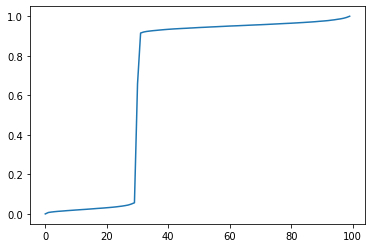

In [ ]:
# hide
plotCurve(curve)